In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Read Train data

In [3]:

train_home_team_statistics_df = pd.read_csv('data/x_train_input/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('data/x_train_input/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('data/y_train_output/y_train_output.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})


In [4]:
train_home_team_statistics_df.head()

,LEAGUE,TEAM_NAME,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Ligue 1,Toulouse,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,...,3.0,0.0,6.0,0.0,10.0,8.0,7.0,2.0,4.0,3.0
1,Ligue 2,Brest,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,...,4.0,0.0,4.0,3.0,10.0,0.0,1.0,2.0,8.0,4.0
2,Serie A,Sampdoria,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,...,4.0,5.0,6.0,3.0,6.0,7.0,2.0,3.0,2.0,4.0
3,League One,Coventry City,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,...,4.0,0.0,1.0,8.0,8.0,5.0,5.0,5.0,NaN,6.0
4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,...,1.0,0.0,2.0,5.0,8.0,7.0,2.0,6.0,4.0,4.0


In [5]:
train_scores.head()

,HOME_WINS,DRAW,AWAY_WINS
ID,,,
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0


## Benchmark

We try to model if AWAY wins

In [6]:
train_new_y = train_scores['AWAY_WINS']

### train, valid test split

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)


### xgb model

In [9]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softprob',
    'num_class': 2,
    'eval_metric':'mlogloss'
    }


d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

num_round = 10000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)


[0]	train-mlogloss:0.68338	eval-mlogloss:0.68785
[1]	train-mlogloss:0.67389	eval-mlogloss:0.68266
[2]	train-mlogloss:0.66467	eval-mlogloss:0.67757
[3]	train-mlogloss:0.65574	eval-mlogloss:0.67304
[4]	train-mlogloss:0.64724	eval-mlogloss:0.66849
[5]	train-mlogloss:0.63894	eval-mlogloss:0.66438
[6]	train-mlogloss:0.63052	eval-mlogloss:0.66062
[7]	train-mlogloss:0.62230	eval-mlogloss:0.65697
[8]	train-mlogloss:0.61454	eval-mlogloss:0.65359
[9]	train-mlogloss:0.60701	eval-mlogloss:0.65015
[10]	train-mlogloss:0.59949	eval-mlogloss:0.64682
[11]	train-mlogloss:0.59224	eval-mlogloss:0.64347
[12]	train-mlogloss:0.58520	eval-mlogloss:0.64026
[13]	train-mlogloss:0.57876	eval-mlogloss:0.63741
[14]	train-mlogloss:0.57188	eval-mlogloss:0.63467
[15]	train-mlogloss:0.56536	eval-mlogloss:0.63191
[16]	train-mlogloss:0.55888	eval-mlogloss:0.62946
[17]	train-mlogloss:0.55254	eval-mlogloss:0.62681
[18]	train-mlogloss:0.54669	eval-mlogloss:0.62444
[19]	train-mlogloss:0.54078	eval-mlogloss:0.62231
[20]	train

### Some analysis

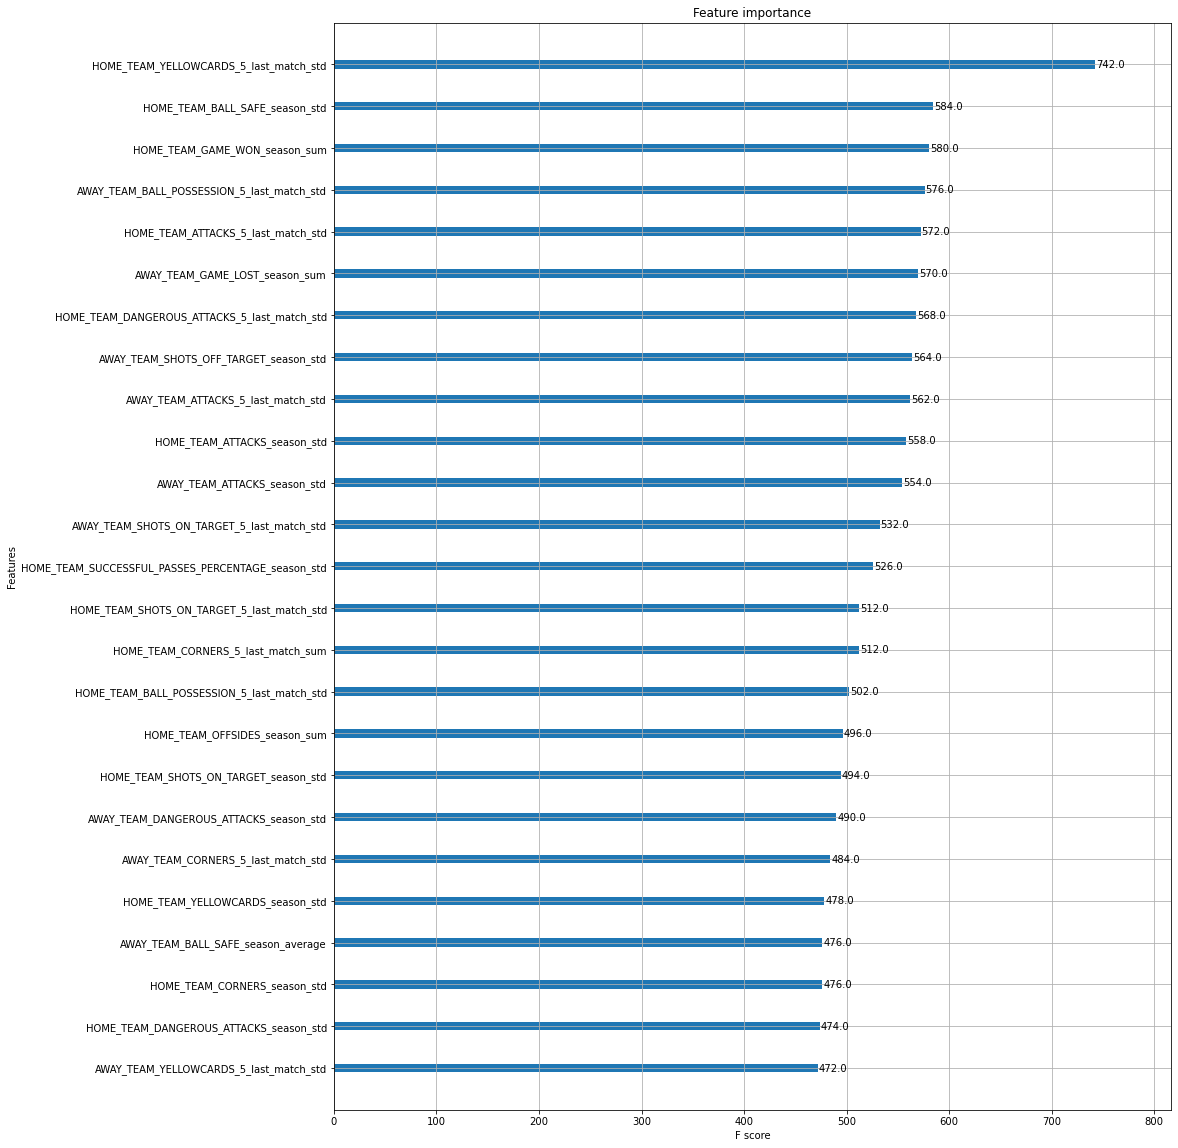

In [10]:
xgb.plot_importance(bst, max_num_features=25)
fig = plt.gcf()
fig.set_size_inches(15, 20)


### Accuracy on test set

A simple benchmark is always predicting home wins

In [12]:
target = train_scores.loc[X_test.index].copy()

home_wins = target
home_wins = 0 * home_wins
home_wins.iloc[:,0] = 1

np.round(accuracy_score(home_wins,target),4)


0.4401

Using our model

In [16]:
X_test_xgb = xgb.DMatrix(X_test)

predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int).values
np.round(accuracy_score(predictions,target),4)


0.4742

## Submission

In [17]:

test_home = pd.read_csv('data/x_test_input/test_home_team_statistics_df.csv', index_col=0)
test_away = pd.read_csv('data/x_test_input/test_away_team_statistics_df.csv', index_col=0)

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)


In [18]:
X_bench = xgb.DMatrix(test_data)

predictions = bst.predict(X_bench, iteration_range=(0, bst.best_iteration))
predictions = pd.DataFrame(predictions)

predictions[2] = 0
predictions.columns = [0,2,1]
predictions = (predictions.reindex(columns=[0,1,2]).rank(1,ascending=False)==1).astype(int)

predictions.columns = ['HOME_WINS', 'DRAW', 'AWAY_WINS']
predictions.index = test_data.index
submission = predictions.reset_index()
submission.to_csv('data/model_outputs/benchmark_submission.csv', index=False)
